In [11]:
# behavior_analysis_tools.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os



In [12]:

# 1. Unified time converter
def time_to_seconds(time_str):
    parts = str(time_str).strip().split(':')
    try:
        if len(parts) == 3:
            h, m, s = map(float, parts)
            return h * 3600 + m * 60 + s
        elif len(parts) == 2:
            m, s = map(float, parts)
            return m * 60 + s
    except:
        return np.nan
    return np.nan

# 2. Standardize dataframe format
def clean_behavior_dataframe(df):
    df.columns = df.columns.str.strip().str.lower()
    if 'event' in df.columns:
        df['event'] = df['event'].str.strip().str.lower()
    if 'trial' in df.columns:
        df['trial'] = pd.to_numeric(df['trial'], errors='coerce')
    return df

# 3. Analyze one behavioral file
def analyze_behavior_data(df):
    df = clean_behavior_dataframe(df)
    df['time_sec'] = df['time'].astype(str).apply(time_to_seconds)

    total_duration = df['time_sec'].max() - df['time_sec'].min()
    trial_numbers = df['trial'].dropna().unique()
    total_trials = len(trial_numbers)

    successful_trials = df[df['event'] == 'target reached']
    successful_trial_numbers = successful_trials['trial'].dropna().unique()
    successful_trials_count = len(successful_trial_numbers)

    successful_rate = successful_trials_count / total_trials if total_trials > 0 else np.nan
    reward_frequency = successful_trials_count / (total_duration / 60) if total_duration > 0 else np.nan

    trial_durations = []
    for trial in trial_numbers:
        trial_times = df[df['trial'] == trial]['time_sec']
        if not trial_times.empty:
            trial_durations.append(trial_times.max() - trial_times.min())

    avg_trial_time = np.mean(trial_durations)
    std_trial_time = np.std(trial_durations)

    return {
        'TotalDuration': total_duration,
        'TotalTrials': total_trials,
        'SuccessfulTrialNumber': successful_trials_count,
        'SuccessfulRate': successful_rate,
        'RewardFrequencyPerMin': reward_frequency,
        'AverageTrialTime': avg_trial_time,
        'StdTrialTime': std_trial_time
    }


In [34]:
df = pd.read_csv("Behavioral data/Survey_Visual_2019-07-23-16-11-36.csv", skiprows=1)
stats = analyze_behavior_data(df)
print(stats)


{'TotalDuration': 1804.4772379999995, 'TotalTrials': 35, 'SuccessfulTrialNumber': 10, 'SuccessfulRate': 0.2857142857142857, 'RewardFrequencyPerMin': 0.33250627237892605, 'AverageTrialTime': 15.680788514285606, 'StdTrialTime': 17.368531633984954}


In [29]:
# List of CSV files
file_paths = [
    "Behavioral data/Survey_Visual_2019-07-23-15-41-47.csv",
    "Behavioral data/Survey_Visual_2019-07-23-16-11-36.csv",
    "Behavioral data/Survey_Visual_2019-07-23-18-22-01.csv",
    "Behavioral data/Survey_Visual_2019-07-23-18-43-55.csv"
]

results = []

for path in file_paths:
    try:
        df = pd.read_csv(path, skiprows=1)
        stats = analyze_behavior_data(df)
        stats['FileName'] = os.path.basename(path)
        results.append(stats)
    except Exception as e:
        print(f"Error processing {path}: {e}")

# Save as CSV
results_df = pd.DataFrame(results)
results_df.to_csv("reward_analysis_results_extended.csv", index=False)
print("Saved to reward_analysis_results_extended.csv")


Saved to reward_analysis_results_extended.csv


In [30]:

# 4. Plot 1D trajectory
def plot_1d_trajectories(df, color_success='g', color_fail='r'):
    df = clean_behavior_dataframe(df)

    if 'position' not in df.columns:
        raise ValueError("Missing 'position' column for plotting trajectory.")

    trial_numbers = df['trial'].dropna().unique()

    plt.figure(figsize=(10, 8))
    plt.title("1D Trial Trajectories (Green: Success, Red: Fail)")
    plt.xlabel("Position (Right = +, Left = -)")
    plt.ylabel("Trial Number")

    for i, trial_id in enumerate(trial_numbers):
        trial_data = df[df['trial'] == trial_id]
        events = trial_data['event'].values

        if 'target reached' in events:
            start_idx = trial_data[trial_data['event'] == 'control applied'].index.min()
            end_idx = trial_data[trial_data['event'] == 'target reached'].index.min()
            if pd.notna(start_idx) and pd.notna(end_idx) and end_idx > start_idx:
                traj = trial_data.loc[start_idx:end_idx, 'position']
                plt.plot(traj.values, [i]*len(traj), color_success, linewidth=1.5)

        elif 'timeout start' in events:
            start_idx = trial_data[trial_data['event'] == 'control applied'].index.min()
            end_idx = trial_data[trial_data['event'] == 'timeout start'].index.min()
            if pd.notna(start_idx) and pd.notna(end_idx) and end_idx > start_idx:
                traj = trial_data.loc[start_idx:end_idx, 'position']
                plt.plot(traj.values, [i]*len(traj), color_fail, linewidth=1.5)

    plt.tight_layout()
    plt.show()

# 5. Plot 2D trajectories
def plot_2d_trajectories(df, show_legend=True):
    df = clean_behavior_dataframe(df)
    df['time_sec'] = df['time'].astype(str).apply(time_to_seconds)

    trial_numbers = df['trial'].dropna().unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(trial_numbers)))

    plt.figure(figsize=(12, 8))
    plt.title("2D Trajectories (Time vs Position per Trial)")
    plt.xlabel("Position")
    plt.ylabel("Time (sec, relative to Control Applied)")

    for i, trial_id in enumerate(trial_numbers):
        trial_data = df[df['trial'] == trial_id]
        events = trial_data['event'].values

        if 'target reached' in events:
            start_idx = trial_data[trial_data['event'] == 'control applied'].index.min()
            end_idx = trial_data[trial_data['event'] == 'target reached'].index.min()
            linestyle = '-'
        elif 'timeout start' in events:
            start_idx = trial_data[trial_data['event'] == 'control applied'].index.min()
            end_idx = trial_data[trial_data['event'] == 'timeout start'].index.min()
            linestyle = '--'
        else:
            continue

        if pd.notna(start_idx) and pd.notna(end_idx) and end_idx > start_idx:
            segment = trial_data.loc[start_idx:end_idx]
            relative_time = segment['time_sec'] - segment['time_sec'].iloc[0]
            position = segment['position'].values
            label = f"Trial {trial_id}"
            plt.plot(position, relative_time, linestyle, color=colors[i], linewidth=1.2, label=label if show_legend else None)

    if show_legend:
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Trials')
    plt.tight_layout()
    plt.show()


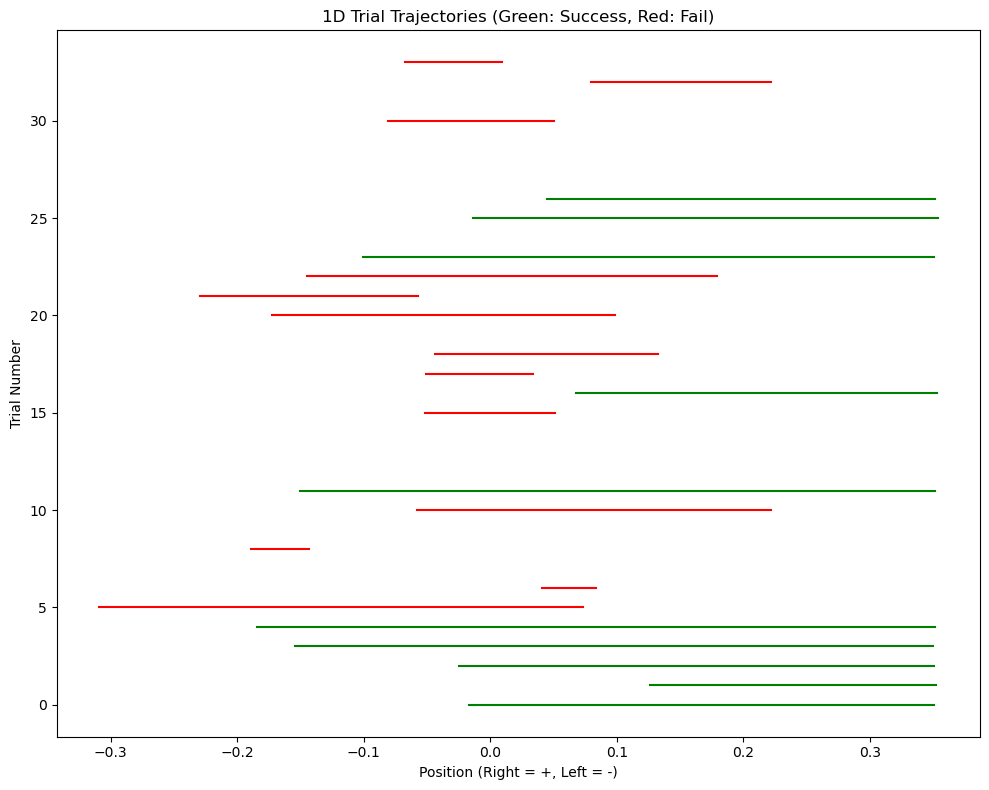

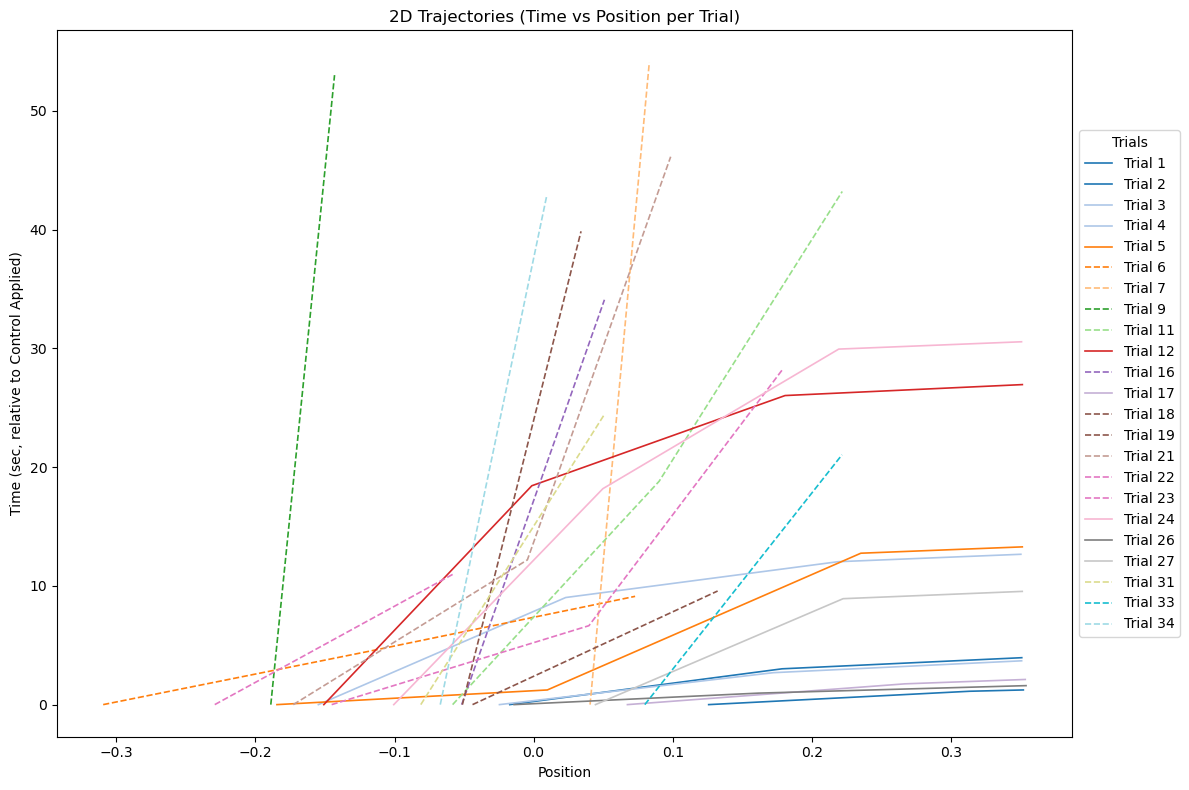

In [35]:
plot_1d_trajectories(df)
plot_2d_trajectories(df)


In [32]:

# 6. Path length analysis
def calculate_path_lengths(df):
    df = clean_behavior_dataframe(df)
    success_path_lengths = []
    fail_path_lengths = []

    trial_numbers = df['trial'].dropna().unique()

    for trial_id in trial_numbers:
        trial_data = df[df['trial'] == trial_id]
        events = trial_data['event'].values

        if 'control applied' in events:
            start_idx = trial_data[trial_data['event'] == 'control applied'].index.min()
        elif 'iti start' in events:
            start_idx = trial_data[trial_data['event'] == 'iti start'].index.min()
        else:
            continue

        if 'target reached' in events:
            end_idx = trial_data[trial_data['event'] == 'target reached'].index.min()
            trial_type = 'success'
        elif 'timeout start' in events:
            end_idx = trial_data[trial_data['event'] == 'timeout start'].index.min()
            trial_type = 'fail'
        else:
            continue

        if pd.notna(start_idx) and pd.notna(end_idx) and end_idx > start_idx:
            start_pos = trial_data.loc[start_idx, 'position']
            end_pos = trial_data.loc[end_idx, 'position']
            path_length = abs(end_pos - start_pos)

            if trial_type == 'success':
                success_path_lengths.append(path_length)
            else:
                fail_path_lengths.append(path_length)

    avg_success_path = np.mean(success_path_lengths) if success_path_lengths else np.nan
    avg_fail_path = np.mean(fail_path_lengths) if fail_path_lengths else np.nan

    return {
        "SuccessPathLengths": success_path_lengths,
        "FailPathLengths": fail_path_lengths,
        "AverageSuccessPath": avg_success_path,
        "AverageFailPath": avg_fail_path
    }


In [36]:
paths = calculate_path_lengths(df)
print(paths)

{'SuccessPathLengths': [0.3679000000000004, 0.2261000000000001, 0.3752000000000003, 0.5047499999999997, 0.5355500000000067, 0.5018999999999939, 0.28585000000000005, 0.4510499999999935, 0.36785, 0.3066500000000024], 'FailPathLengths': [0.3821999999999993, 0.042550000000005396, 0.0457999999999871, 0.2799500000000028, 0.1025500000000091, 0.08525000000000871, 0.1761000000000026, 0.2711500000000014, 0.1717499999999987, 0.3246000000000032, 0.1316500000000058, 0.1417000000000064, 0.0763999999999887], 'AverageSuccessPath': 0.39227999999999974, 'AverageFailPath': 0.17166538461538605}


In [19]:

# 7. Ensemble bar plot with SE and n-number
def plot_ensemble_barplots(df, ensemble_col='Ensemble'):
    df = df.copy()
    df[ensemble_col] = pd.to_numeric(df[ensemble_col], errors='coerce')
    df = df.dropna(subset=[ensemble_col])

    ensembles = sorted(df[ensemble_col].unique())
    colors = plt.cm.tab20(np.linspace(0, 1, len(ensembles)))

    summary = {
        'Ensemble': [], 'AvgSuccessfulRate': [], 'SESuccessfulRate': [],
        'AvgRewardFrequency': [], 'SERewardFrequency': [],
        'AvgTrialTime': [], 'SETrialTime': [], 'N': []
    }

    for ens in ensembles:
        group = df[df[ensemble_col] == ens]
        n = len(group)
        summary['Ensemble'].append(ens)
        summary['AvgSuccessfulRate'].append(group['SuccessfulRate'].mean())
        summary['SESuccessfulRate'].append(group['SuccessfulRate'].std(ddof=1) / np.sqrt(n))
        summary['AvgRewardFrequency'].append(group['RewardFrequencyPerMin'].mean())
        summary['SERewardFrequency'].append(group['RewardFrequencyPerMin'].std(ddof=1) / np.sqrt(n))
        summary['AvgTrialTime'].append(group['AverageTrialTime'].mean())
        summary['SETrialTime'].append(group['AverageTrialTime'].std(ddof=1) / np.sqrt(n))
        summary['N'].append(n)

    summary_df = pd.DataFrame(summary)

    def plot_single(y, yerr, ylabel, title, ylim):
        x = summary_df['Ensemble']
        n_labels = summary_df['N']
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(x, y, yerr=yerr, capsize=5, color=colors[:len(x)])
        for xi, yi, err, n in zip(x, y, yerr, n_labels):
            label_y = yi + err + 0.03 * max(y) if err > 0 else yi + 0.03 * max(y)
            ax.text(xi, label_y, f"n = {n}", ha='center', fontsize=10)
        ax.set_xlabel("Ensemble")
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.set_ylim(ylim)
        ax.set_xticks(x)
        fig.tight_layout()
        plt.show()

    plot_single(summary_df['AvgSuccessfulRate'], summary_df['SESuccessfulRate'],
                "Success Rate", "Success Rate by Ensemble", ylim=(0, 1.1))

    plot_single(summary_df['AvgRewardFrequency'], summary_df['SERewardFrequency'],
                "Reward Frequency (per min)", "Reward Frequency by Ensemble",
                ylim=(0, max(summary_df['AvgRewardFrequency']) + 2))

    plot_single(summary_df['AvgTrialTime'], summary_df['SETrialTime'],
                "Average Trial Time (s)", "Average Trial Time by Ensemble",
                ylim=(0, max(summary_df['AvgTrialTime']) + 5))


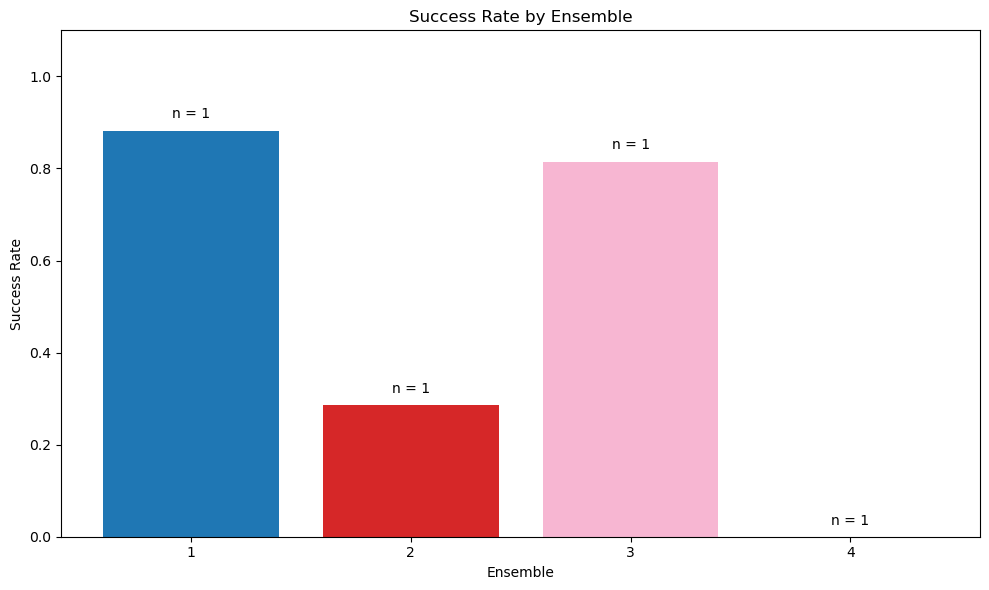

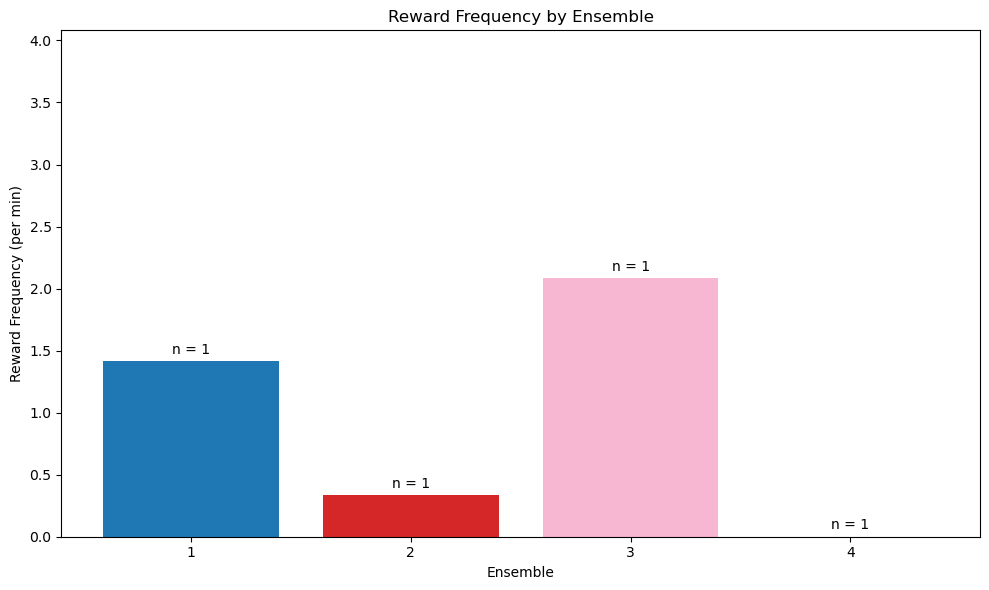

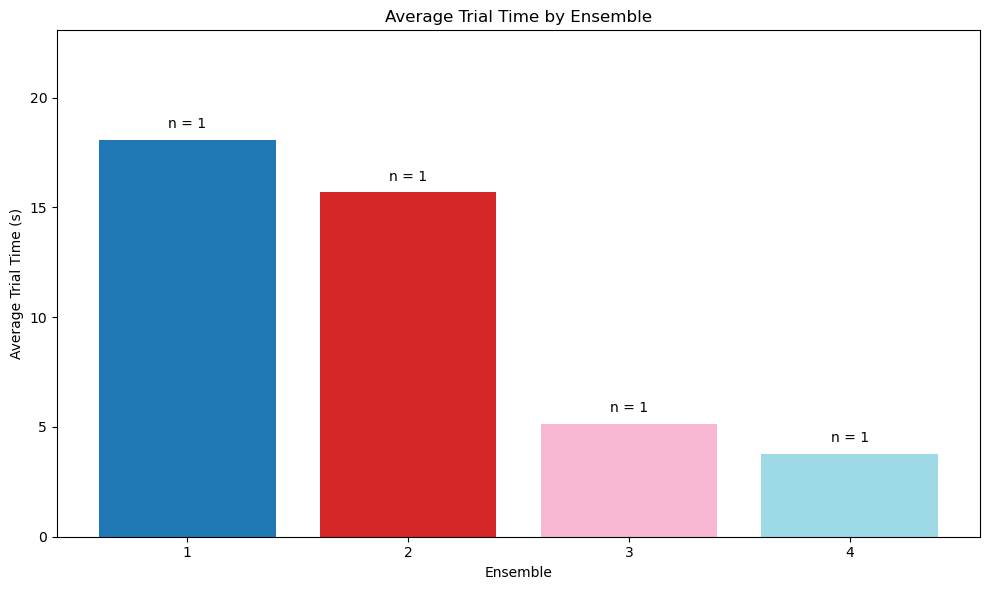

In [40]:
df2 = pd.read_csv('reward_analysis_results_extended.csv')
plot_ensemble_barplots(df2)